In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [3]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.
Message: Elephant
Embedding size: 512
Embedding: [0.044984735548496246, -0.05743392929434776, 0.0022114552557468414, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.055680178105831146, -0.009607919491827488, 0.0062462822534143925, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [0.03874940052628517, 0.0765201598405838, -0.0007945773540996015, ...]



In [4]:
def get_embeddings(messages):
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
        message_embeddings = session.run(embed(messages))
    return message_embeddings

In [5]:
def get_embedding_summary(messages):
    return get_embeddings(messages).mean(axis = 1)

In [137]:
def plot_similarity(labels, features, rotation):
    features = np.array(features)
    corr = np.corrcoef(features, features)
    corr = corr[:len(features), :len(features)]
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return features

def run_and_plot_groups(session_, input_tensor_, list_of_messages_, encoding_tensor):
    topic_embeddings = []
    for topic, messages_ in list_of_messages_.items():
        message_embeddings_ = session_.run(
          encoding_tensor, feed_dict={input_tensor_: messages_})
        topic_embeddings.append(message_embeddings_.mean(axis=0))
    return plot_similarity(list_of_messages_.keys(), topic_embeddings, 90)

def run_and_plot(session_, input_tensor_, list_of_messages_, encoding_tensor):
    message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: list_of_messages_})
    plot_similarity(list_of_messages_, message_embeddings_, 90)

(11, 11)


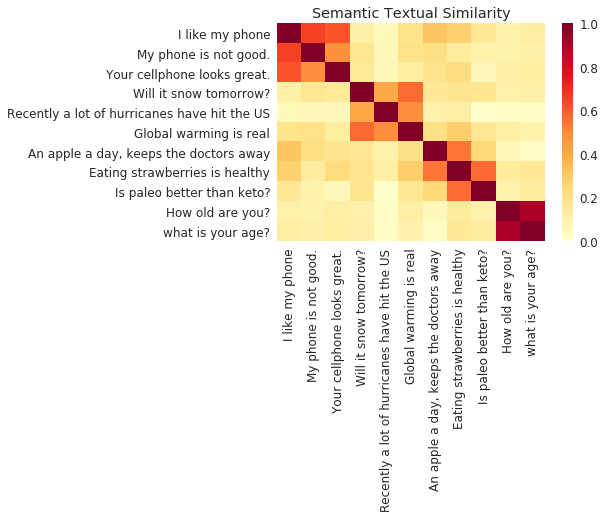

In [7]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)

## News Data 

In [122]:
def plot_topic_coherence_per_topic(list_of_topics):
    topic_messages = {}
    for topic, messages in list_of_topics.items():
        try:
            int(topic)
        except:
            continue
        topic_messages[topic] = [' '.join(article.strip().split()[:10]) for article in messages[:5]]
    similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
    similarity_message_encodings = embed(similarity_input_placeholder)
    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      session.run(tf.tables_initializer())
      return run_and_plot_groups(session, similarity_input_placeholder, topic_messages,
                   similarity_message_encodings)

In [28]:
def plot_topic_coherence(lists_of_topic_examples):
    topic_lists = []
    for topic, messages in lists_of_topic_examples.items():
        try:
            int(topic)
        except:
            continue
        if len(topic_lists) > 15:
            break
        if len(messages) > 100 and np.random.rand()>0.5:
            continue
        topic_lists.extend([' '.join(article.strip().split()[:10]) for article in messages[:2]])
    similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
    similarity_message_encodings = embed(similarity_input_placeholder)
    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      session.run(tf.tables_initializer())
      run_and_plot(session, similarity_input_placeholder, topic_lists,
                   similarity_message_encodings)

In [10]:
topic_data = pd.read_csv('lda_articles.csv', header=None, names=['topicID','article'])

In [11]:
list_of_topics = {}
for i, df in topic_data.groupby('topicID'):
    x = df['article'].values
    if(len(x)>100):
        np.random.shuffle(x)
        list_of_topics[str(i)] = x[:5]

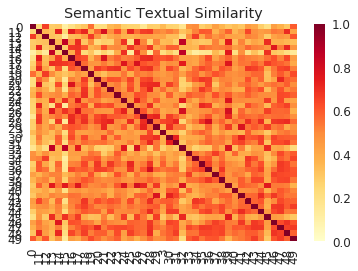

In [138]:
features = plot_topic_coherence_per_topic(list_of_topics)

In [140]:
from sklearn.preprocessing import StandardScaler
x_std = StandardScaler().fit_transform(features)
cov = np.cov(x_std.T)
ev , eig = np.linalg.eig(cov)
a = eig.dot(x_std.T)

In [144]:
len(eig)

512

In [139]:
np.cov(features, features)

array([[0.00150792, 0.00034003, 0.00079832, ..., 0.00042284, 0.00034274,
        0.00063581],
       [0.00034003, 0.00130879, 0.00040183, ..., 0.00054301, 0.00072437,
        0.00041891],
       [0.00079832, 0.00040183, 0.00096338, ..., 0.0004127 , 0.00039118,
        0.00051849],
       ...,
       [0.00042284, 0.00054301, 0.0004127 , ..., 0.00081635, 0.00053091,
        0.00052352],
       [0.00034274, 0.00072437, 0.00039118, ..., 0.00053091, 0.00079878,
        0.00045291],
       [0.00063581, 0.00041891, 0.00051849, ..., 0.00052352, 0.00045291,
        0.00074603]])

In [131]:
np.corrcoef(features, features)

array([[1.        , 0.24204487, 0.66235011, ..., 0.3811085 , 0.3122931 ,
        0.59945735],
       [0.24204487, 1.        , 0.35785762, ..., 0.52533248, 0.70845467,
        0.42394611],
       [0.66235011, 0.35785762, 1.        , ..., 0.46536884, 0.44593365,
        0.61159802],
       ...,
       [0.3811085 , 0.52533248, 0.46536884, ..., 1.        , 0.65746424,
        0.67083561],
       [0.3122931 , 0.70845467, 0.44593365, ..., 0.65746424, 1.        ,
        0.58670804],
       [0.59945735, 0.42394611, 0.61159802, ..., 0.67083561, 0.58670804,
        1.        ]])

(16, 16)


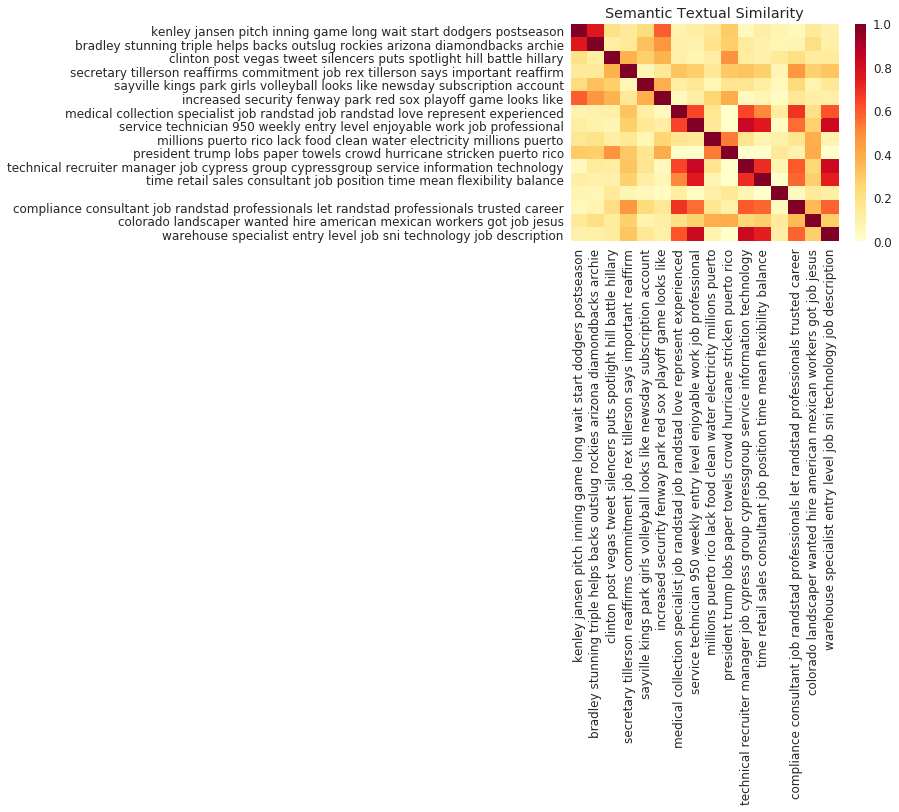

In [29]:
plot_topic_coherence(list_of_topics)

## Tweets 

In [30]:
tweet_data = pd.read_csv('./Tweets_Week20171002.csv')

In [31]:
en_tweets = tweet_data[tweet_data.lang=='en ']

In [34]:
selected_tweets = en_tweets

In [35]:
tweet_embeddings = get_embeddings(selected_tweets.text.values)

In [36]:
tweet_embeddings[0]

array([ 0.00984685, -0.03136912, -0.08139064,  0.06166908,  0.02867527,
        0.02596113, -0.02459262,  0.06563472, -0.03228243,  0.00972516,
       -0.03500921,  0.02863309, -0.02392416, -0.01610552,  0.03979526,
       -0.0631844 , -0.05169431,  0.03055625, -0.07506853,  0.00030145,
        0.00828682, -0.00400223,  0.0358612 ,  0.06245915,  0.08350737,
       -0.02912491, -0.02627392,  0.04848239, -0.03273377, -0.04708475,
       -0.04282684, -0.08053375, -0.07020228, -0.06302037, -0.03463319,
       -0.07857744, -0.01876749,  0.02290034,  0.05676433,  0.05358392,
        0.04118634,  0.0377196 , -0.05726932,  0.02699143, -0.06494889,
        0.02426731, -0.05293017,  0.13457361, -0.00918143, -0.04226638,
       -0.009369  , -0.03181621, -0.05736171, -0.03641559,  0.04807721,
       -0.0947509 ,  0.01069758,  0.08729823,  0.05201945, -0.0279882 ,
       -0.02318838, -0.03852832, -0.02226262, -0.01188782,  0.03504484,
       -0.06582368, -0.07490837,  0.05075407,  0.01232517, -0.02

In [37]:
import nmslib

In [38]:
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(tweet_embeddings)
index.createIndex({'post': 2}, print_progress=True)

In [39]:
# query for the nearest neighbours of the first datapoint
ids, distances = index.knnQuery(tweet_embeddings[10], k=10)

In [40]:
ids, distances

(array([  10, 4830, 2869, 4829,  898, 2555, 5041, 3720, 2345, 5060],
       dtype=int32),
 array([1.19209290e-07, 7.52886534e-02, 1.12353444e-01, 1.13555670e-01,
        1.38639450e-01, 1.46839261e-01, 1.48998380e-01, 1.71706676e-01,
        1.71847105e-01, 2.17673540e-01], dtype=float32))

In [41]:
print(selected_tweets.iloc[ids].text.values)

['NRA met w/Putin then poured $30M into Trump campaign. Their unprecedented support seems to have paid off. 1/\n#maddow https://t.co/iZAEm2jccb '
 'Remember, the #NRA donated more than $30m to get Trump elected #GunControlNow #LasVegasShooting https://t.co/xYgBQwc3vf '
 '.@NRA spent over $30,000,000 to elect Donald Trump.\n\nTrump spoke at @NRA convention\n\nHe praises @NRA at almost ever… https://t.co/oDsOXDwuwK '
 'The NRA spent more than $30 million to put Donald Trump in the White House--more than any other outside group: https://t.co/NAhPsXXvyW '
 'NRA spent $30 million getting Trump elected so of course no calls for tougher gun laws–just a tweet that reads like… https://t.co/5bBGN9wTKY '
 'NRA delegation met with the Russian Govt in Moscow right before spending $30.3 million on Trump in 2016 election\n\nhttps://t.co/VK5YPJ3VLw '
 '@funder @PopularPres2016 The NRA was so impressed with Russia`s plan that they felt good about giving up a 30 million dollar payoff to trump '
 'At som

## News Index 

In [44]:
topic_id = 3

In [45]:
topic_data.head(10)

,topicID,article
0,43,woman says return home shot woman grew 42nd pr...
1,46,scientists develop smart tattoo detects health...
2,36,supreme court declines case lengthy juvenile s...
3,49,las vegas festival center shooting big draw fa...
4,ringing stage hitting trailers people scatte...,NaN
5,tonight horrific wrote,NaN
6,thoughts prayers involved tonight hurts hear...,NaN
7,49,giants need fire jerry reese fire jerry reese ...
8,48,palestinian gaza major reconciliation effort b...
9,way statehood unity hamdallah speaking welco...,NaN


In [56]:
def get_index_for_topic(topic_id):
    df = topic_data[topic_data.topicID==str(topic_id)]
    x = df['article'].values
    np.random.shuffle(x)
    x = [' '.join(article.strip().split()[:20]) for article in x]
    return x

In [108]:
processed_topic = get_index_for_topic(28)

In [112]:
len(processed_topic), processed_topic[-15:]

(837,
 ['commandos niger soldier killed attack niger army special operations commandos partner nation member killed attack niger southwest providing assistance security',
  'images february images taken reuters photographers world month february 2017 including battle retake mosul weeks trump presidency carnival celebrations produced',
  'men arrested plot bomb nyc subway times square men charged isis inspired plot bomb times square canadian citizen inspired islamic',
  'azure solution architect expertise data lake analytics job talentburst inc talentburst award winning accounting finance staffing firm headquartered boston branch',
  'iraqi announces recapture bastion hawija subscriber print edition subscriber don login',
  'islamic state claims las vegas mass shooting graphic released monday oct 2017 amaq news agency media arm islamic state group',
  'suspected drone strike kills qaida fighters yemen police officer yells mother leaving children hot car',
  'anti nuclear campaign ican w

In [113]:
embedded_topic = get_embedding_summary(processed_topic)

In [114]:
ids, distances = index.knnQuery(embedded_topic, k=10)

In [115]:
print(selected_tweets.iloc[ids].text.values)

['@EdKrassen @IRdotnet @realDonaldTrump Left needs to stop promoting resistance and freak the calm down already. ENOU… https://t.co/TzFwTAm3gh '
 'The Patriot Act/ NDAA is Declared Martial Law. A Police State. Fascism \n. https://t.co/30tMmv2WH9\n@realDonaldTrump '
 'Our democracy is fading. This is unconstitutional and another step towards authoritarianism. https://t.co/ASRtXx6Po1 '
 '#TakeAKnee is peaceful protest. Trump hates protesters &amp; exploits patriotism &amp; citizens to silence dissent https://t.co/Hm1wcHj3Ml '
 'No One Will Stop Our President TRUMP Revolution of...\n\nChristians\nVeterans\nCitizens\nMilitary\nFamily\nHonor \nValor \n&amp;… https://t.co/Nq2JPgCBro '
 '@realDonaldTrump @VP @SecondLady They`re not disrespecting our country. They`re peaceful protesting. \nAnyways, what… https://t.co/Lla8nPuKAA '
 '@TonyStapleton12 @LouDobbs @realDonaldTrump Antifa better think twice about what they are fighting cause they look… https://t.co/C8vsRjwlTl '
 '“Requiring governmen